In [32]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from dateutil.relativedelta import relativedelta

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn import linear_model
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True, precision=4)
pd.options.display.float_format = '{:.4f}'.format
pd.set_option("display.max_columns", None)
plt.style.use('seaborn')
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = 'IPAexGothic'

# Ch.04 顧客の行動を予測する

スポーツジムの会員データを使って顧客の行動を分析する。  
３章で顧客の全体像を把握した。  
ここからは、機械学習を用いて顧客のグループ化や顧客の利用予測行なっていく。  
ここでは、教師なし学習、教師あり学習の回帰を取り扱う。

データ概要

- use_log.csv
  - ジムの利用履歴データ
  - 2018-04~2019-03
- customer_master.csv
  - 2019-03末時点の会員データ
- class_master.csv
  - 会員区分データ（オールタイム・デイタイム・ナイト）
- campaign_master.csv
  - キャンペーン区分データ（入会無料等）
- customer_join.csv
  - Ch.03で作成した利用履歴を含んだ顧客データ

### Knock31: データの読み込み

- 「use_log.csv」と「customer_join.csv」を読み込む

In [2]:
# 「use_log.csv」を読み込む

uselog = pd.read_csv("../support/4章/use_log.csv")
uselog.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [3]:
# 「customer_join.csv」を読み込む

customer = pd.read_csv("../support/4章/customer_join.csv")
customer.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

### Knock32: クラスタリングで顧客をグループ化する

In [4]:
# クラスタリングに用いる変数
# customer["mean", "median", "max", "min", "membership_period"]

customer_clustering = customer[["mean", "median", "max", "min", "membership_period"]]
print(customer_clustering.shape)
display(customer_clustering)

(4192, 5)


,mean,median,max,min,membership_period
0,4.8333,5.0000,8,2,47
1,5.0833,5.0000,7,3,47
2,4.5833,5.0000,6,3,47
3,4.8333,4.5000,7,2,47
4,3.9167,4.0000,6,1,47
...,...,...,...,...,...
4187,8.0000,8.0000,8,8,1
4188,10.0000,10.0000,10,10,1
4189,8.0000,8.0000,8,8,1
4190,11.0000,11.0000,11,11,1


In [5]:
# K-means法
# 変数化の距離をベースにグループ化する
# 4つのグループに分ける

# 標準化
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)

# Kmeansモデル構築
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit(customer_clustering_sc)
customer_clustering = customer_clustering.assign(cluster=clusters.labels_)

print(customer_clustering["cluster"].unique())
display(customer_clustering)

[1 2 3 0]


,mean,median,max,min,membership_period,cluster
0,4.8333,5.0000,8,2,47,1
1,5.0833,5.0000,7,3,47,1
2,4.5833,5.0000,6,3,47,1
3,4.8333,4.5000,7,2,47,1
4,3.9167,4.0000,6,1,47,1
...,...,...,...,...,...,...
4187,8.0000,8.0000,8,8,1,0
4188,10.0000,10.0000,10,10,1,0
4189,8.0000,8.0000,8,8,1,0
4190,11.0000,11.0000,11,11,1,0


### Knock33: クラスタリング結果を分析する

In [6]:
# 列名の変更
customer_clustering.columns = [
    "月内平均値", "月内中央値", "月内最大値", "月内最小値", "会員期間", "cluster"
]

display(customer_clustering)

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間,cluster
0,4.8333,5.0000,8,2,47,1
1,5.0833,5.0000,7,3,47,1
2,4.5833,5.0000,6,3,47,1
3,4.8333,4.5000,7,2,47,1
4,3.9167,4.0000,6,1,47,1
...,...,...,...,...,...,...
4187,8.0000,8.0000,8,8,1,0
4188,10.0000,10.0000,10,10,1,0
4189,8.0000,8.0000,8,8,1,0
4190,11.0000,11.0000,11,11,1,0


In [7]:
# グループごとのデータ件数

customer_clustering.groupby("cluster").count()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,840,840,840,840,840
1,1249,1249,1249,1249,1249
2,771,771,771,771,771
3,1332,1332,1332,1332,1332


In [8]:
# グループごとの平均値

customer_clustering.groupby("cluster").mean()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,8.0619,8.0470,10.0143,6.1750,7.0190
1,4.6776,4.6709,7.2338,2.1537,36.9159
2,3.0655,2.9001,4.7834,1.6498,9.2763
3,5.5395,5.3911,8.7560,2.7027,14.8679


- グループ0: 会員期間が短い、利用率が高い
- グループ1: 会員期間が長い、グループ3より利用率が低い
- グループ2: 会員期間が短い、最も利用率が低い
- グループ3: 会員期間が最も長い

### Knock34: クラスタリング結果を可視化する

In [9]:
# 2次元上にプロットするため、次元削除を行う
# 次元削除の手法である主成分分析を行う

X = customer_clustering_sc
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df["cluster"] = customer_clustering["cluster"]

display(pca_df)

,0,1,cluster
0,-0.8200,-1.9591,1
1,-0.7079,-1.7999,1
2,-1.0615,-1.6598,1
3,-1.1608,-1.8101,1
4,-2.0171,-1.6701,1
...,...,...,...
4187,3.0279,1.1396,0
4188,5.0647,0.7697,0
4189,3.0279,1.1396,0
4190,6.0831,0.5847,0


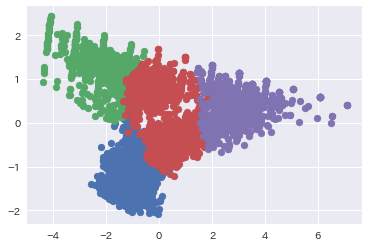

In [10]:
# 次元削除による可視化

for i in customer_clustering["cluster"].unique():
    tmp = pca_df.loc[pca_df["cluster"] == i]
    plt.scatter(tmp[0], tmp[1])

### Knock35: クラスタリング結果をもとに退会ユーザーの傾向を把握する

In [11]:
# 退会顧客を特定するため、customer_clusteringに、
# customer["is_deleted"]を追加する

customer_clustering = pd.concat([customer_clustering, customer], axis=1)

In [13]:
# "cluster", "is_deleted"ごとに、
# "customer_id"の件数を集計する

customer_clustering.groupby(
    ["cluster", "is_deleted"], as_index=False
).count()[["cluster", "is_deleted", "customer_id"]]


,cluster,is_deleted,customer_id
0,0,0,821
1,0,1,19
2,1,0,1231
3,1,1,18
4,2,1,771
5,3,0,790
6,3,1,542


- グループ0（会員期間が短い、利用率が高い）
- グループ1（会員期間が長い、グループ3より利用率が低い）
  - 継続顧客が多い
- グループ2（会員期間が短い、最も利用率が低い）
  - 退会顧客が多い
- グループ3（会員期間が最も長い）
  - 継続顧客と退会顧客の差が少ない

In [14]:
# 定期利用しているかの確認
# "cluster", "routine_flg"ごとに、
# "customer_id"の件数を集計する

customer_clustering.groupby(
    ["cluster", "routine_flg"], as_index=False
).count()[["cluster", "routine_flg", "customer_id"]]

,cluster,routine_flg,customer_id
0,0,0,52
1,0,1,788
2,1,0,2
3,1,1,1247
4,2,0,499
5,2,1,272
6,3,0,226
7,3,1,1106


- グループ0（会員期間が短い、利用率が高い、継続顧客が多い）
  - 定期利用している顧客が多い
- グループ1（会員期間が長い、グループ3より利用率が低い、継続顧客が多い）
  - 定期利用している顧客が多い
- グループ2（会員期間が短い、最も利用率が低い、退会顧客が多い）
  - 定期利用している顧客が少ない
- グループ3（会員期間が最も長い、継続顧客と退会顧客の差が少ない）
  - 定期利用している顧客が多い

### Knock36: 翌月の利用回数予測を行うためのデータを準備する

- 教師あり学習の回帰

In [16]:
# uselogデータの確認

display(uselog)

,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01
...,...,...,...
197423,L00000049209753,TS977703,2019-03-31
197424,L00000049209754,TS979550,2019-03-31
197425,L00000049209755,TS995299,2019-03-31
197426,L00000049209756,TS995853,2019-03-31


In [17]:
# uselogデータから、年月別の各顧客の利用回数の集計

# datetime型に変換
uselog['usedate'] = pd.to_datetime(uselog["usedate"])
# "年月"列の追加
uselog["年月"] = uselog["usedate"].dt.strftime("%Y%m")

# 月別の各顧客の利用回数
uselog_months = uselog.groupby(["年月", "customer_id"], as_index=False).count()
uselog_months.rename(columns={"log_id": "count"}, inplace=True)
del uselog_months["usedate"]

display(uselog_months)

,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7
...,...,...,...
36837,201903,TS995853,8
36838,201903,TS998593,8
36839,201903,TS999079,3
36840,201903,TS999231,6


In [20]:
uselog_months["年月"].unique()

array(['201804', '201805', '201806', '201807', '201808', '201809',
       '201810', '201811', '201812', '201901', '201902', '201903'],
      dtype=object)

In [27]:
year_months = list(uselog_months["年月"].unique())
predict_data = pd.DataFrame()

# 直近6ヶ月の利用回数を抽出する（201810~201903）
for i in range(6, len(year_months)):  # i = 6~11(count=6)
    tmp = uselog_months.loc[uselog_months["年月"] == year_months[i]].copy()
    tmp.rename(columns={"count": "count_pred"}, inplace=True)
    # 該当月（201810~201903）の過去6ヶ月の利用回数を抽出する
    for j in range(1, 7):  # j = 1~6(count=6)
        tmp_before = uselog_months.loc[uselog_months["年月"] == year_months[i-j]].copy()
        del tmp_before["年月"]
        tmp_before.rename(columns={"count": "count_{}".format(j-1)}, inplace=True)
        tmp = pd.merge(tmp, tmp_before, on="customer_id", how="left")
    predict_data = pd.concat([predict_data, tmp], ignore_index=True, axis=0)

display(predict_data)

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0000,3.0000,5.0000,5.0000,5.0000,4.0000
1,201810,AS008805,2,2.0000,5.0000,7.0000,8.0000,NaN,NaN
2,201810,AS009373,5,6.0000,6.0000,7.0000,4.0000,4.0000,3.0000
3,201810,AS015233,7,9.0000,11.0000,5.0000,7.0000,7.0000,NaN
4,201810,AS015315,4,7.0000,3.0000,6.0000,3.0000,3.0000,6.0000
...,...,...,...,...,...,...,...,...,...
18305,201903,TS995853,8,11.0000,NaN,NaN,NaN,NaN,NaN
18306,201903,TS998593,8,7.0000,8.0000,7.0000,9.0000,9.0000,9.0000
18307,201903,TS999079,3,2.0000,6.0000,9.0000,6.0000,6.0000,4.0000
18308,201903,TS999231,6,6.0000,3.0000,8.0000,5.0000,5.0000,4.0000


In [28]:
# 欠損値の除去

# 欠損値のある行の削除
predict_data = predict_data.dropna()
# indexの初期化
predict_data = predict_data.reset_index(drop=True)
display(predict_data)

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0000,3.0000,5.0000,5.0000,5.0000,4.0000
1,201810,AS009373,5,6.0000,6.0000,7.0000,4.0000,4.0000,3.0000
2,201810,AS015315,4,7.0000,3.0000,6.0000,3.0000,3.0000,6.0000
3,201810,AS015739,5,6.0000,5.0000,8.0000,6.0000,5.0000,7.0000
4,201810,AS019860,7,5.0000,7.0000,4.0000,6.0000,8.0000,6.0000
...,...,...,...,...,...,...,...,...,...
15108,201903,TS995299,3,3.0000,5.0000,4.0000,5.0000,4.0000,5.0000
15109,201903,TS998593,8,7.0000,8.0000,7.0000,9.0000,9.0000,9.0000
15110,201903,TS999079,3,2.0000,6.0000,9.0000,6.0000,6.0000,4.0000
15111,201903,TS999231,6,6.0000,3.0000,8.0000,5.0000,5.0000,4.0000


### Knock37: 特徴となる変数を付与する

In [29]:
# predict_dataに、
# customer["start_date"]を追加する

predict_data = pd.merge(
    predict_data, customer[["customer_id", "start_date"]],
    on="customer_id",
    how="left"
)
display(predict_data)

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,201810,AS002855,3,7.0000,3.0000,5.0000,5.0000,5.0000,4.0000,2016-11-01
1,201810,AS009373,5,6.0000,6.0000,7.0000,4.0000,4.0000,3.0000,2015-11-01
2,201810,AS015315,4,7.0000,3.0000,6.0000,3.0000,3.0000,6.0000,2015-07-01
3,201810,AS015739,5,6.0000,5.0000,8.0000,6.0000,5.0000,7.0000,2017-06-01
4,201810,AS019860,7,5.0000,7.0000,4.0000,6.0000,8.0000,6.0000,2017-10-01
...,...,...,...,...,...,...,...,...,...,...
15108,201903,TS995299,3,3.0000,5.0000,4.0000,5.0000,4.0000,5.0000,2015-09-01
15109,201903,TS998593,8,7.0000,8.0000,7.0000,9.0000,9.0000,9.0000,2018-09-01
15110,201903,TS999079,3,2.0000,6.0000,9.0000,6.0000,6.0000,4.0000,2016-06-01
15111,201903,TS999231,6,6.0000,3.0000,8.0000,5.0000,5.0000,4.0000,2017-03-01


In [30]:
# 会員期間（月単位）を算出する
# "年月" - "start_date"

# datetime型に変換
predict_data["now_date"] = pd.to_datetime(predict_data["年月"], format="%Y%m")
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])

predict_data["period"] = None
for i in range(len(predict_data)):
    # 会員期間を求める
    delta = relativedelta(
        predict_data.loc[i, "now_date"], predict_data.loc[i, "start_date"]
    )
    # 会員期間（月単位）変換する
    predict_data.loc[i, "period"] = delta.years*12 + delta.months

display(predict_data)

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period
0,201810,AS002855,3,7.0000,3.0000,5.0000,5.0000,5.0000,4.0000,2016-11-01,2018-10-01,23
1,201810,AS009373,5,6.0000,6.0000,7.0000,4.0000,4.0000,3.0000,2015-11-01,2018-10-01,35
2,201810,AS015315,4,7.0000,3.0000,6.0000,3.0000,3.0000,6.0000,2015-07-01,2018-10-01,39
3,201810,AS015739,5,6.0000,5.0000,8.0000,6.0000,5.0000,7.0000,2017-06-01,2018-10-01,16
4,201810,AS019860,7,5.0000,7.0000,4.0000,6.0000,8.0000,6.0000,2017-10-01,2018-10-01,12
...,...,...,...,...,...,...,...,...,...,...,...,...
15108,201903,TS995299,3,3.0000,5.0000,4.0000,5.0000,4.0000,5.0000,2015-09-01,2019-03-01,42
15109,201903,TS998593,8,7.0000,8.0000,7.0000,9.0000,9.0000,9.0000,2018-09-01,2019-03-01,6
15110,201903,TS999079,3,2.0000,6.0000,9.0000,6.0000,6.0000,4.0000,2016-06-01,2019-03-01,33
15111,201903,TS999231,6,6.0000,3.0000,8.0000,5.0000,5.0000,4.0000,2017-03-01,2019-03-01,24


### Knock38: 来月の利用回数予測モデルを作成する

- 「201804」以降に新規入会した顧客に絞ってモデルを作成する
  - 古くからいる顧客は入会時のデータが存在しない
  - 利用回数が安定状態に入っている可能性がある
- 使用する回帰モデル
  - linearRegression（線形回帰モデル）

In [33]:
# 線形回帰モデルの作成

# 入会日「20180401」以降の顧客を抽出
predict_data = predict_data.loc[predict_data["start_date"] >= pd.to_datetime("20180401")]

# 線形回帰モデルの初期化
model = linear_model.LinearRegression()
# 説明変数
X = predict_data[[
    "count_0", "count_1", "count_2", "count_3", "count_4", "count_5", "period"
]]
# 目的変数
y = predict_data["count_pred"]

# 学習用データ、評価用データの分割（train=0.75, test=0.25）
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
# 予測モデルの構築
model.fit(X_train, y_train)

LinearRegression()

In [34]:
# 回帰モデルの精度

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.6111525903215709
0.5964633323568842


### Knock39: モデルに寄与している変数を確認する

In [35]:
# 目的変数に寄与している説明変数の係数を出力する

coef = pd.DataFrame({
    "feature_names": X.columns,
    "coefficient": model.coef_
})
display(coef)

,feature_names,coefficient
0,count_0,0.3591
1,count_1,0.1819
2,count_2,0.1512
3,count_3,0.1846
4,count_4,0.0769
5,count_5,0.0587
6,period,0.0470


### Knock40: 来月の利用回数を予測する

In [37]:
# 新規データの作成

x1 = [3, 4, 4, 6, 8, 7, 8]
x2 = [2, 2, 3, 3, 4, 6, 8]
x_pred = pd.DataFrame(
    data=[x1, x2],
    columns=["count_0", "count_1", "count_2", "count_3", "count_4", "count_5", "period"]
)

In [38]:
# 作成したモデルを用いて予測する

model.predict(x_pred)

array([3.7701, 1.9756])

In [ ]:
# uselog_monthsデータを出力する

uselog_months.to_csv("uselog_months.csv", index=False)